# Perfect Cookies Test

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies, versions_key, compare_versions

In [3]:
from perfect_cookies import preprocessing, count_perfect_cookies, plot_cookies_dist
import perfect_cookies
import hard_rules

In [4]:
from tqdm import tqdm

In [5]:
sns.set(rc={'figure.figsize':(12,5)})

In [6]:
%load_ext autoreload
%autoreload 2

## Reading the data

In [90]:
data = pd.read_parquet('../Data/10K_HH.parquet')

In [91]:
maid_chosen = "third_party"

In [402]:
df = preprocessing(data)

In [93]:
df_sorted = df.sort_values(by='time')

In [94]:
df_sorted = df_sorted[df_sorted["time"] >= pd.to_datetime("2022-12-01")]

In [95]:
df_sorted["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2022, 12)    3039691
(2023, 1)     3063579
(2023, 2)     1383089
Name: time, dtype: int64

In [96]:
two_thirds_index = int(len(df_sorted) * 2/3)

In [97]:
train = df_sorted.iloc[:two_thirds_index]
test = df_sorted.iloc[two_thirds_index:]

## Lets Predict

In [231]:
import re

In [232]:
only_relevant_maid = train[train["maid"] == perfect_cookies.maid2int(maid_chosen)]

In [233]:
pattern = re.compile(r'^\d+(\.\d+)*$')
only_relevant_maid = only_relevant_maid[only_relevant_maid.osversion.str.match(pattern)]

In [234]:
more_than_one = only_relevant_maid.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [235]:
grouped_data = more_than_one.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg(
    {'browserversion': [hard_rules.min_ver, hard_rules.max_ver], 'osversion': [hard_rules.min_ver, hard_rules.max_ver],
     'time': ['min', 'max']}).reset_index()

In [236]:
grouped_data.columns = ['hh_id', 'brand', 'model', 
                        'os', 'browser', 'advertisedbrowser', 'iiqid', 
                        'min_browser_ver', 'max_browser_ver', 
                        'min_os_ver', 'max_os_ver', 
                        'min_time', 'max_time']

In [237]:
grouped_data = grouped_data.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [264]:
grouped_ages = (end_of_time - grouped_data.groupby([
    'hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'
            ])["min_time"].max()).apply(lambda t: t.days)
print(len(grouped_ages))
print(len(grouped_data))
# grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1)

8291
24703


In [265]:
grouped_data['prev_max_time'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)
grouped_data['prev_max_browser_ver'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_browser_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)
grouped_data['prev_max_os_ver'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_os_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)

In [266]:
full_valid_rows = grouped_data[(grouped_data['min_time'] > grouped_data['prev_max_time'])
                              & (np.vectorize(compare_versions)(grouped_data['min_browser_ver'], 
                                                               grouped_data['prev_max_browser_ver']) >= 0)
                              & (np.vectorize(compare_versions)(grouped_data['min_os_ver'], 
                                                               grouped_data['prev_max_os_ver']) >= 0)]

In [354]:
end_of_time = pd.Timestamp('2023-02-24')

In [272]:
original_rows_per_hhua = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
last_cookie_age_per_hhua = (end_of_time - grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])["min_time"].max()).apply(lambda t: t.days)
valid_rows_per_hhua = full_valid_rows.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable = valid_rows_per_hhua.eq(original_rows_per_hhua)

result = pd.concat([original_rows_per_hhua, all_mergable, last_cookie_age_per_hhua], axis=1)
result.columns = ['cookies','mergeable', 'last_cookie_age'] 

In [273]:
result.head()

,,,,,,cookies,mergeable,last_cookie_age
hh_id,brand,model,os,browser,advertisedbrowser,,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False,81
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True,65
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True,62
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False,65
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False,50


### Now Lets reveal the last third a.k.a the test

In [109]:
only_relevant_maid_full = df_sorted[df_sorted["maid"] == perfect_cookies.maid2int(maid_chosen)]

In [110]:
pattern = re.compile(r'^\d+(\.\d+)*$')
only_relevant_maid_full = only_relevant_maid_full[only_relevant_maid_full.osversion.str.match(pattern)]

In [111]:
more_than_one_full = only_relevant_maid_full.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [112]:
grouped_data_full = more_than_one_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg(
    {'browserversion': [hard_rules.min_ver, hard_rules.max_ver], 'osversion': [hard_rules.min_ver, hard_rules.max_ver],
     'time': ['min', 'max']}).reset_index()

In [113]:
grouped_data_full.columns = ['hh_id', 'brand', 'model', 
                        'os', 'browser', 'advertisedbrowser', 'iiqid', 
                        'min_browser_ver', 'max_browser_ver', 
                        'min_os_ver', 'max_os_ver', 
                        'min_time', 'max_time']

In [114]:
grouped_data_full = grouped_data_full.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [115]:
grouped_data_full['prev_max_time'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)
grouped_data_full['prev_max_browser_ver'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_browser_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)
grouped_data_full['prev_max_os_ver'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_os_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)

In [116]:
full_valid_rows_full = grouped_data_full[(grouped_data_full['min_time'] > grouped_data_full['prev_max_time'])
                              & (np.vectorize(compare_versions)(grouped_data_full['min_browser_ver'], 
                                                               grouped_data_full['prev_max_browser_ver']) >= 0)
                              & (np.vectorize(compare_versions)(grouped_data_full['min_os_ver'], 
                                                               grouped_data_full['prev_max_os_ver']) >= 0)]

In [117]:
original_rows_per_hhua_full = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
valid_rows_per_hhua_full = full_valid_rows_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable_full = valid_rows_per_hhua_full.eq(original_rows_per_hhua_full)

result_full = pd.concat([original_rows_per_hhua_full, all_mergable_full], axis=1)
result_full.columns = ['cookies_full','mergeable_full'] 

In [118]:
result_full.head()

,,,,,,cookies_full,mergeable_full
hh_id,brand,model,os,browser,advertisedbrowser,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False


In [274]:
tested_train = result.join(result_full, how='left')

In [284]:
tested_train.head()

,,,,,,cookies,mergeable,last_cookie_age,cookies_full,mergeable_full
hh_id,brand,model,os,browser,advertisedbrowser,,,,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False,81,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True,65,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True,62,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False,65,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False,50,2,False


In [403]:
accuracy_by_age = tested_train.groupby('last_cookie_age').apply(lambda x: (x.loc[(x['mergeable']==True) & (x['mergeable_full']==True)].shape[0]) / x.loc[x['mergeable']==True].shape[0])

In [416]:
for i in range(min(accuracy_by_age.index), max(accuracy_by_age.index)):
    print(len(tested_train[(tested_train["last_cookie_age"]==i) & (tested_train["mergeable"]==True)]))

66
100
114
96
89
90
59
95
65
68
57
70
62
51
64
61
46
52
57
48
38
54
50
46
41
56
59
45
54
29
47
45
40
40
31
40
37
20
20
20
18
17
16
21
18
10
51
69
43
27


In [342]:
from numpy.polynomial.polynomial import polyfit

In [440]:
x = np.array(accuracy_by_age.index)
y = np.array(accuracy_by_age)

b, m = polyfit(x=accuracy_by_age.index, y=accuracy_by_age, deg=1)
coeffs = polyfit(x, y, deg=2)

In [441]:
coeffs

array([ 1.44852081e-01,  1.87593300e-02, -1.20146318e-04])

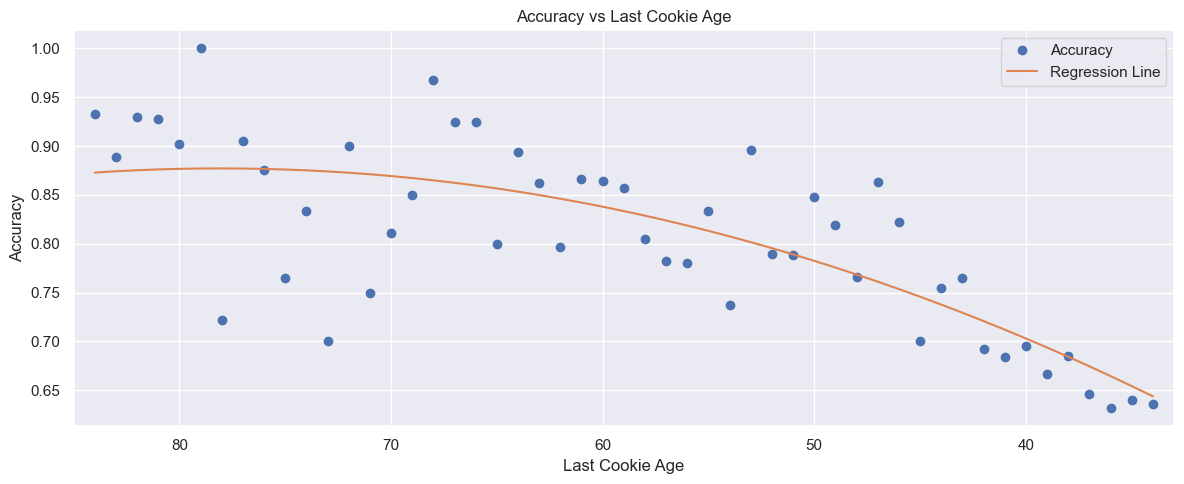

In [443]:
# plt.plot(accuracy_by_age, 'o-')
plt.plot(x, y, 'o', label='Accuracy')
plt.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line')
# plt.plot(accuracy_by_age.index, b + m * accuracy_by_age.index, '-', label='Regression Line')
plt.xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
print("How many merges didn't get ruined")
print('{:.1%}'.format((tested_train["mergeable"]==tested_train["mergeable_full"]).sum()/len(tested_train)))

How many merges didn't get ruined
93.3%


In [123]:
print("How many didn't change at all")
print('{:.1%}'.format((tested_train["cookies"]==tested_train["cookies_full"]).sum()/len(tested_train)))

How many didn't change at all
74.7%


In [128]:
print("From those who changed, how many merges didn't get ruined")
changed_total = tested_train[tested_train["cookies"]!=tested_train["cookies_full"]]
changed_but_still_ok = changed_total[changed_total["mergeable"]==changed_total["mergeable_full"]]

print('{:.1%}'.format(len(changed_but_still_ok)/len(changed_total)))

From those who changed, how many merges didn't get ruined
88.3%


### Now for every broswer

In [284]:
tested_train.head()

,,,,,,cookies,mergeable,last_cookie_age,cookies_full,mergeable_full
hh_id,brand,model,os,browser,advertisedbrowser,,,,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False,81,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True,65,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True,62,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False,65,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False,50,2,False


In [392]:
b = "chrome mobile"

In [398]:
tested_train_by_browser = tested_train.reset_index()[tested_train.reset_index()["browser"]==b]

In [399]:
accuracy_by_age_by_browser = tested_train_by_browser.groupby('last_cookie_age').apply(lambda x: (x.loc[x['mergeable'] == x['mergeable_full']].shape[0]) / x.shape[0])

In [400]:
b, m = polyfit(x=accuracy_by_age_by_browser.index, y=accuracy_by_age_by_browser, deg=1)

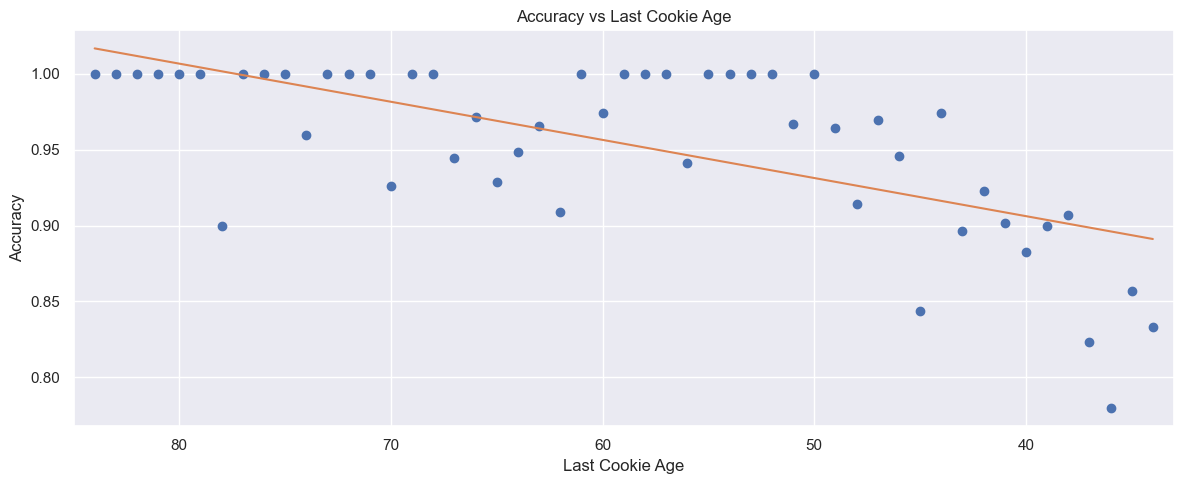

In [401]:
# plt.plot(accuracy_by_age, 'o-')
plt.plot(accuracy_by_age_by_browser.index, accuracy_by_age_by_browser, 'o')
plt.plot(accuracy_by_age_by_browser.index, b + m * accuracy_by_age_by_browser.index, '-')
plt.xlim(accuracy_by_age_by_browser.index.max()+1, accuracy_by_age_by_browser.index.min()-1)
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.tight_layout()
plt.show()

2067

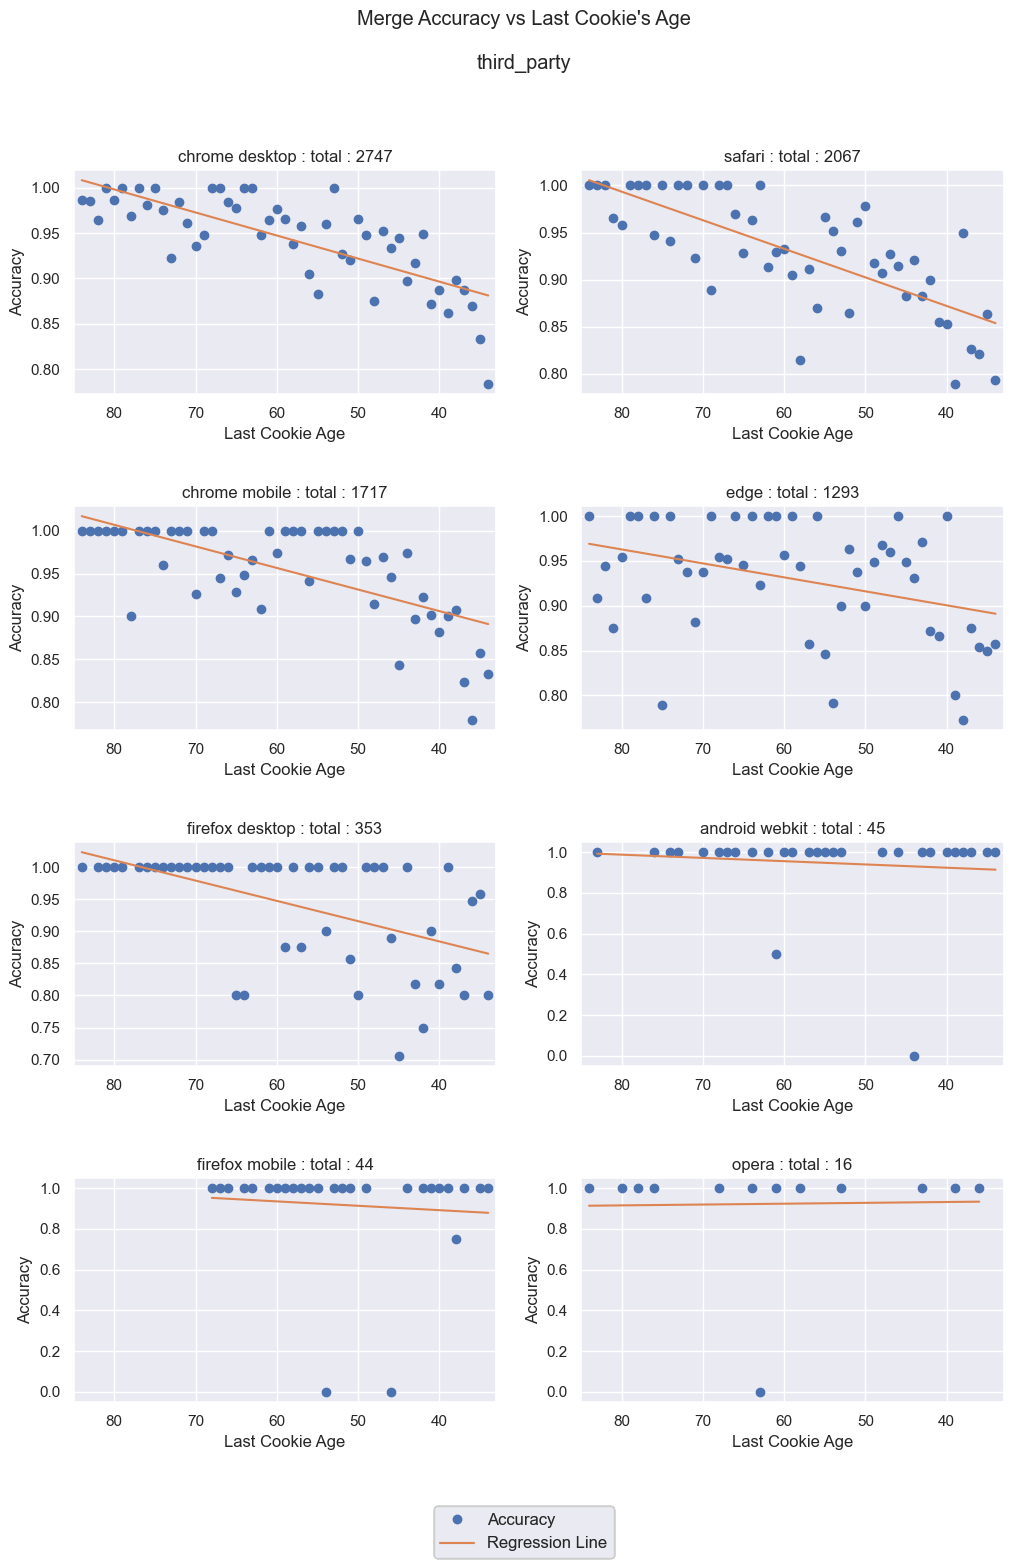

In [475]:
fig, axs = plt.subplots(nrows = 4, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(12)
plt.subplots_adjust(hspace=0.5)
fig.suptitle(f"Merge Accuracy vs Last Cookie's Age\n\n{maid_chosen}")

top_browsers = tested_train.reset_index().browser.value_counts()[:8].index

for i, b in enumerate(top_browsers):
    ax = axs.flatten()[i]
    
    tested_train_by_browser = tested_train.reset_index()[tested_train.reset_index()["browser"]==b]
    accuracy_by_age_by_browser = tested_train_by_browser.groupby('last_cookie_age').apply(lambda x: (x.loc[x['mergeable'] == x['mergeable_full']].shape[0]) / x.shape[0])
    total_count_for_browser = tested_train.reset_index().browser.value_counts().loc[b]
    
    x = np.array(accuracy_by_age_by_browser.index)
    y = np.array(accuracy_by_age_by_browser)
    coeffs = polyfit(x, y, deg=1)
    ax.plot(x, y, 'o', label='Accuracy')
    # ax.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line')
    ax.plot(x, coeffs[0] + coeffs[1] * x, '-', label='Regression Line')
    
    ax.title.set_text(f"{b} : total : {total_count_for_browser}")
    ax.set_xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)
    ax.set_xlabel('Last Cookie Age')
    ax.set_ylabel('Accuracy')
    # ax.set_title('Accuracy vs Last Cookie Age')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize='medium', bbox_to_anchor=(0.5, 0.05))    

## Scale up the data - 100K

In [7]:
import gc

In [21]:
gc.collect()

1288

In [9]:
data = pd.read_csv('../Data/100KHH7.csv')

In [30]:
data.head()

,timestamp,filename,maid,hh_id,iiqid,partner_id,ip,iscellip,cellispid,domain,...,brand,model,os,osversion,browser,advertisedbrowser,browserversion,type,is_best_ip,time
0,1671485334960,HH_M,7,0rbVVSZ9hT,ypsxOpa2dh,15317,1813854856,False,1256337485,1468002127,...,microsoft,edge,windows,10,edge,Edge,108.0.1462.54,desktop,False,2022-12-19 21:28:54.960
1,1671485333183,HH_M,7,0rbVVSZ9hT,ypsxOpa2dh,15106,1813854856,False,1256337485,1468002127,...,microsoft,edge,windows,10,edge,Edge,108.0.1462.54,desktop,False,2022-12-19 21:28:53.183
2,1674180419682,HH_M,7,0dY6RH1DOS,dkfC5h1G2p,15019,2487401185,False,-1841348430,20133086,...,mozilla,firefox,windows,10,firefox desktop,Firefox,108.0,desktop,False,2023-01-20 02:06:59.682
3,1674180419440,HH_M,7,0dY6RH1DOS,dkfC5h1G2p,15019,2487401185,False,-1841348430,-91937866,...,mozilla,firefox,windows,10,firefox desktop,Firefox,108.0,desktop,False,2023-01-20 02:06:59.440
4,1674093351017,HH_M,7,0dY6RH1DOS,dkfC5h1G2p,15127,2487401185,False,-1841348430,-91937866,...,mozilla,firefox,windows,10,firefox desktop,Firefox,108.0,desktop,False,2023-01-19 01:55:51.017


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36528704 entries, 0 to 36644572
Data columns (total 21 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   timestamp                 int64         
 1   filename                  object        
 2   maid                      int64         
 3   hh_id                     object        
 4   iiqid                     object        
 5   partner_id                int64         
 6   ip                        int64         
 7   iscellip                  bool          
 8   cellispid                 int64         
 9   domain                    int64         
 10  is_house_ip_or_source_ip  bool          
 11  brand                     object        
 12  model                     object        
 13  os                        object        
 14  osversion                 object        
 15  browser                   object        
 16  advertisedbrowser         object        
 17  browse

In [29]:
data['time'] = pd.to_datetime(data['timestamp'], unit='ms')

In [32]:
data.dropna(inplace=True)

In [23]:
# data['is_hh'] = data['hh_id'].apply(lambda x: isinstance(x, str))

In [24]:
# data.is_hh.value_counts()

In [25]:
# data['hh_id'] = data['hh_id'].astype(str)

Save the preprosecced data

In [34]:
data.to_parquet('100KHH7.parquet')

In [ ]:
# data = pd.read_parquet('../Data/10K_HH.parquet')

### Now lets test

In [35]:
maid_chosen = "third_party"

In [36]:
df_sorted = data.sort_values(by='time')

In [37]:
df_sorted = df_sorted[df_sorted["time"] >= pd.to_datetime("2022-12-01")]

In [38]:
df_sorted["time"].apply(lambda t: (t.year, t.month)).value_counts().sort_index()

(2022, 12)    11646145
(2023, 1)     12914353
(2023, 2)     11964937
Name: time, dtype: int64

In [39]:
two_thirds_index = int(len(df_sorted) * 2/3)

In [40]:
train = df_sorted.iloc[:two_thirds_index]
test = df_sorted.iloc[two_thirds_index:]

#### The first step of the test

In [41]:
import re

In [42]:
only_relevant_maid = train[train["maid"] == perfect_cookies.maid2int(maid_chosen)]

In [43]:
pattern = re.compile(r'^\d+(\.\d+)*$')
only_relevant_maid = only_relevant_maid[only_relevant_maid.osversion.str.match(pattern)]

In [44]:
more_than_one = only_relevant_maid.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [46]:
del data

In [62]:
gc.collect()

78472

In [51]:
def has_nonnumeric_chars(string):
    for char in string:
        if not (char.isdigit() or char == '.'):
            return True
    return False

In [53]:
nonnumeric = more_than_one.loc[more_than_one.browserversion.apply(has_nonnumeric_chars), "browserversion"]

In [60]:
"{:.5%}".format(len(nonnumeric)/len(more_than_one))

'0.00080%'

In [61]:
more_than_one = more_than_one[~more_than_one.browserversion.apply(has_nonnumeric_chars)]

In [63]:
grouped_data = more_than_one.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg(
    {'browserversion': [hard_rules.min_ver, hard_rules.max_ver], 'osversion': [hard_rules.min_ver, hard_rules.max_ver],
     'time': ['min', 'max']}).reset_index()

In [64]:
grouped_data.columns = ['hh_id', 'brand', 'model', 
                        'os', 'browser', 'advertisedbrowser', 'iiqid', 
                        'min_browser_ver', 'max_browser_ver', 
                        'min_os_ver', 'max_os_ver', 
                        'min_time', 'max_time']

In [65]:
grouped_data = grouped_data.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [69]:
end_of_time = pd.Timestamp('2023-02-28')

In [70]:
grouped_ages = (end_of_time - grouped_data.groupby([
    'hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'
            ])["min_time"].max()).apply(lambda t: t.days)
print(len(grouped_ages))
print(len(grouped_data))
# grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1)

93599
297398


In [71]:
grouped_data['prev_max_time'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)
grouped_data['prev_max_browser_ver'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_browser_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)
grouped_data['prev_max_os_ver'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_os_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)

In [72]:
full_valid_rows = grouped_data[(grouped_data['min_time'] > grouped_data['prev_max_time'])
                              & (np.vectorize(compare_versions)(grouped_data['min_browser_ver'], 
                                                               grouped_data['prev_max_browser_ver']) >= 0)
                              & (np.vectorize(compare_versions)(grouped_data['min_os_ver'], 
                                                               grouped_data['prev_max_os_ver']) >= 0)]

In [73]:
end_of_time = pd.Timestamp('2023-02-24')

In [74]:
original_rows_per_hhua = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
last_cookie_age_per_hhua = (end_of_time - grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])["min_time"].max()).apply(lambda t: t.days)
valid_rows_per_hhua = full_valid_rows.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable = valid_rows_per_hhua.eq(original_rows_per_hhua)

result = pd.concat([original_rows_per_hhua, all_mergable, last_cookie_age_per_hhua], axis=1)
result.columns = ['cookies','mergeable', 'last_cookie_age'] 

#### Now Lets reveal the last third a.k.a the test

In [75]:
only_relevant_maid_full = df_sorted[df_sorted["maid"] == perfect_cookies.maid2int(maid_chosen)]

In [76]:
pattern = re.compile(r'^\d+(\.\d+)*$')
only_relevant_maid_full = only_relevant_maid_full[only_relevant_maid_full.osversion.str.match(pattern)]

In [81]:
more_than_one_full = only_relevant_maid_full.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [82]:
more_than_one_full = more_than_one_full[~more_than_one_full.browserversion.apply(has_nonnumeric_chars)]

In [83]:
grouped_data_full = more_than_one_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg(
    {'browserversion': [hard_rules.min_ver, hard_rules.max_ver], 'osversion': [hard_rules.min_ver, hard_rules.max_ver],
     'time': ['min', 'max']}).reset_index()

In [84]:
grouped_data_full.columns = ['hh_id', 'brand', 'model', 
                        'os', 'browser', 'advertisedbrowser', 'iiqid', 
                        'min_browser_ver', 'max_browser_ver', 
                        'min_os_ver', 'max_os_ver', 
                        'min_time', 'max_time']

In [85]:
grouped_data_full = grouped_data_full.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [86]:
grouped_data_full['prev_max_time'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)
grouped_data_full['prev_max_browser_ver'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_browser_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)
grouped_data_full['prev_max_os_ver'] = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_os_ver'].shift(1).fillna(hard_rules.MINUS_INF_VERSION)

In [87]:
full_valid_rows_full = grouped_data_full[(grouped_data_full['min_time'] > grouped_data_full['prev_max_time'])
                              & (np.vectorize(compare_versions)(grouped_data_full['min_browser_ver'], 
                                                               grouped_data_full['prev_max_browser_ver']) >= 0)
                              & (np.vectorize(compare_versions)(grouped_data_full['min_os_ver'], 
                                                               grouped_data_full['prev_max_os_ver']) >= 0)]

In [88]:
original_rows_per_hhua_full = grouped_data_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
valid_rows_per_hhua_full = full_valid_rows_full.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable_full = valid_rows_per_hhua_full.eq(original_rows_per_hhua_full)

result_full = pd.concat([original_rows_per_hhua_full, all_mergable_full], axis=1)
result_full.columns = ['cookies_full','mergeable_full'] 

In [89]:
result_full.head()

cookies_full  \
hh_id      brand     model  os        browser        advertisedbrowser                 
0001z5np75 apple     iphone ios       safari         Mobile Safari                 5   
           google    chrome macos     chrome desktop Chrome                        4   
0005gBVGI5 google    chrome chrome os chrome desktop Chrome                        4   
                            windows   chrome desktop Chrome                        5   
           microsoft edge   windows   edge           Edge                          2   

                                                                        mergeable_full  
hh_id      brand     model  os        browser        advertisedbrowser                  
0001z5np75 apple     iphone ios       safari         Mobile Safari               False  
           google    chrome macos     chrome desktop Chrome                      False  
0005gBVGI5 google    chrome chrome os chrome desktop Chrome                       True  
                            windows   chrome desktop Chrome                      False  
           microsoft edge   windows   edge           Edge                         True

In [90]:
tested_train = result.join(result_full, how='left')

In [91]:
tested_train.head()

cookies  \
hh_id      brand  model  os        browser        advertisedbrowser            
0001z5np75 apple  iphone ios       safari         Mobile Safari            3   
           google chrome macos     chrome desktop Chrome                   4   
0005gBVGI5 google chrome chrome os chrome desktop Chrome                   4   
                         windows   chrome desktop Chrome                   4   
000D1TTj2K google chrome windows   chrome desktop Chrome                   2   

                                                                     mergeable  \
hh_id      brand  model  os        browser        advertisedbrowser              
0001z5np75 apple  iphone ios       safari         Mobile Safari           True   
           google chrome macos     chrome desktop Chrome                 False   
0005gBVGI5 google chrome chrome os chrome desktop Chrome                  True   
                         windows   chrome desktop Chrome                 False   
000D1TTj2K google chrome windows   chrome desktop Chrome                  True   

                                                                     last_cookie_age  \
hh_id      brand  model  os        browser        advertisedbrowser                    
0001z5np75 apple  iphone ios       safari         Mobile Safari                   75   
           google chrome macos     chrome desktop Chrome                          53   
0005gBVGI5 google chrome chrome os chrome desktop Chrome                          35   
                         windows   chrome desktop Chrome                          58   
000D1TTj2K google chrome windows   chrome desktop Chrome                          45   

                                                                     cookies_full  \
hh_id      brand  model  os        browser        advertisedbrowser                 
0001z5np75 apple  iphone ios       safari         Mobile Safari                 5   
           google chrome macos     chrome desktop Chrome                        4   
0005gBVGI5 google chrome chrome os chrome desktop Chrome                        4   
                         windows   chrome desktop Chrome                        5   
000D1TTj2K google chrome windows   chrome desktop Chrome                        2   

                                                                     mergeable_full  
hh_id      brand  model  os        browser        advertisedbrowser                  
0001z5np75 apple  iphone ios       safari         Mobile Safari               False  
           google chrome macos     chrome desktop Chrome                      False  
0005gBVGI5 google chrome chrome os chrome desktop Chrome                       True  
                         windows   chrome desktop Chrome                      False  
000D1TTj2K google chrome windows   chrome desktop Chrome                       True

In [92]:
accuracy_by_age = tested_train.groupby('last_cookie_age').apply(lambda x: (x.loc[(x['mergeable']==True) & (x['mergeable_full']==True)].shape[0]) / x.loc[x['mergeable']==True].shape[0])

In [94]:
from numpy.polynomial.polynomial import polyfit

In [95]:
x = np.array(accuracy_by_age.index)
y = np.array(accuracy_by_age)

b, m = polyfit(x=accuracy_by_age.index, y=accuracy_by_age, deg=1)
coeffs = polyfit(x, y, deg=2)

In [96]:
coeffs

array([ 5.07882730e-01,  7.91292080e-03, -4.38188751e-05])

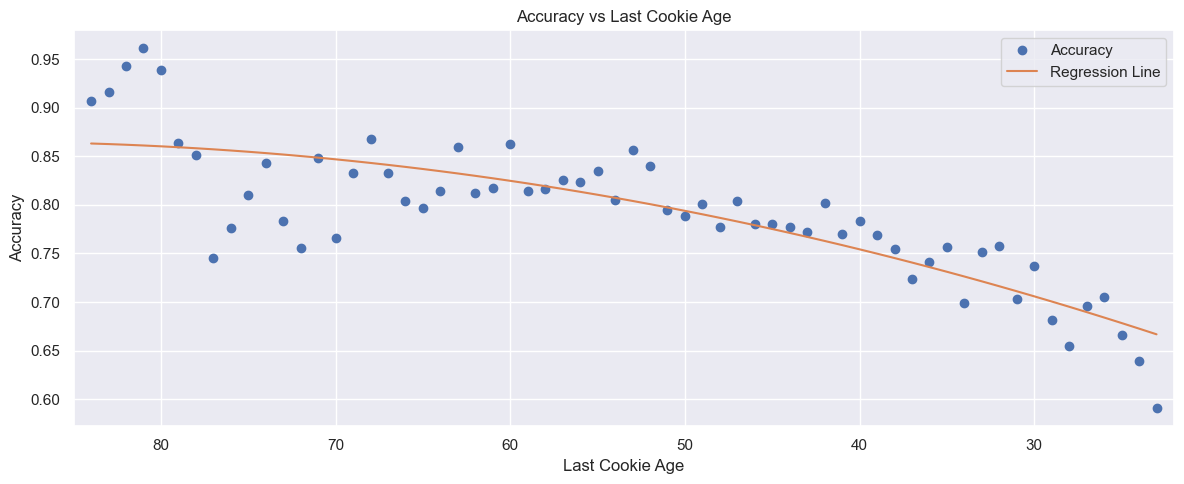

In [97]:
# plt.plot(accuracy_by_age, 'o-')
plt.plot(x, y, 'o', label='Accuracy')
plt.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line')
# plt.plot(accuracy_by_age.index, b + m * accuracy_by_age.index, '-', label='Regression Line')
plt.xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.legend()
plt.tight_layout()
plt.show()

##### Compare to random noise from the curve

In [101]:
# for i in range(min(accuracy_by_age.index), max(accuracy_by_age.index)):
#     print(len(tested_train[(tested_train["last_cookie_age"]==i) & (tested_train["mergeable"]==True)]))

In [115]:
def age_size(age):
    return len(tested_train[(tested_train["last_cookie_age"]==age) & (tested_train["mergeable"]==True)])

In [116]:
def curve(age):
    return coeffs[0] + coeffs[1] * age + coeffs[2] * age**2

In [117]:
p = curve(50)
n = age_size(50)
print(p)
print(np.random.binomial(n, p) / n)

0.7939815816563255
0.8122362869198312


In [123]:
noisy_curve = [np.random.binomial(age_size(age), curve(age)) / age_size(age) for age in accuracy_by_age.index]

In [153]:
stds = [np.sqrt(curve(age)*(1-curve(age))/age_size(age)) for age in accuracy_by_age.index]

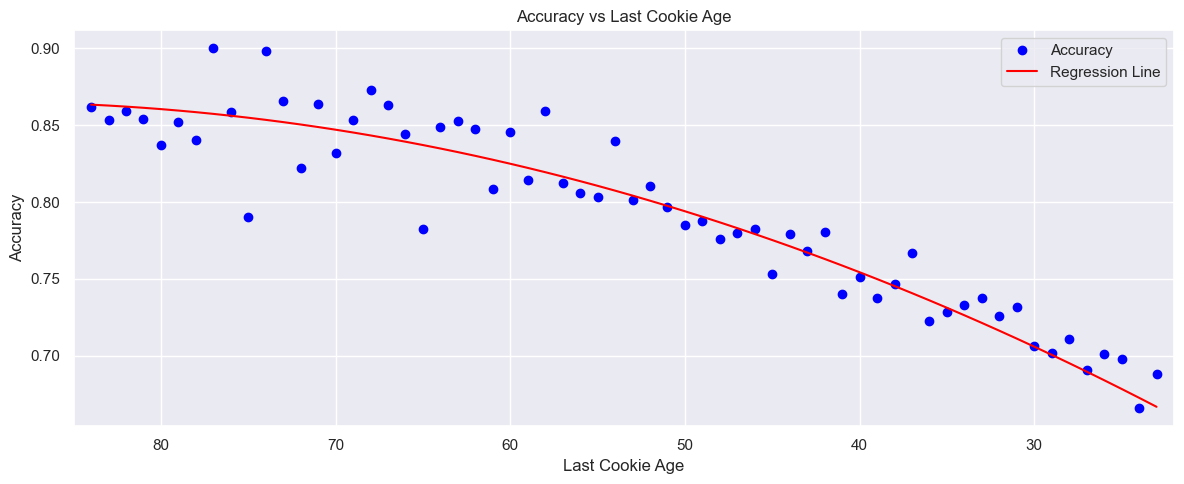

In [169]:
plt.plot(x, noisy_curve, 'o', label='Accuracy', color="blue")
plt.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line', color="red")
# plt.plot(accuracy_by_age.index, b + m * accuracy_by_age.index, '-', label='Regression Line')
plt.xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)
# plt.errorbar(x, noisy_curve, yerr=stds, fmt='o-', capsize=4, ecolor="grey")
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.legend()
plt.tight_layout()
plt.show()

(85.0, 22.0)

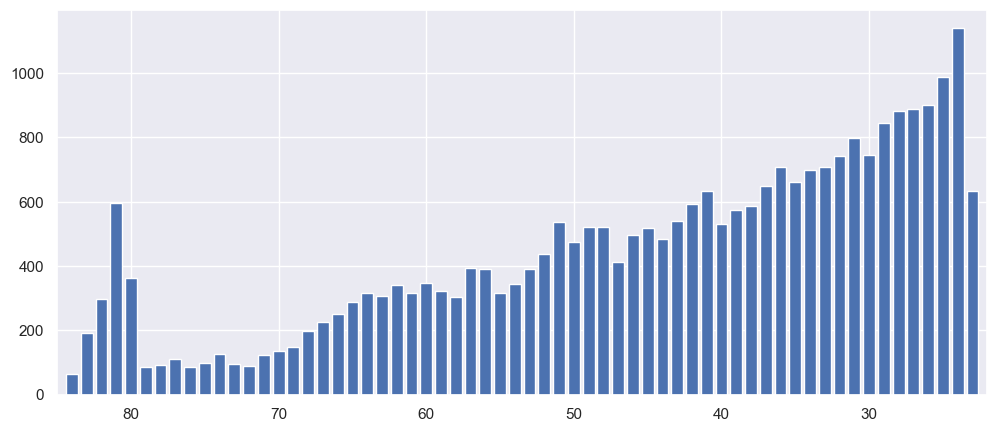

In [158]:
plt.bar(accuracy_by_age.index, [age_size(i) for i in accuracy_by_age.index])
plt.xlim(accuracy_by_age.index.max()+1, accuracy_by_age.index.min()-1)

#### Another version

In [126]:
tested_train_merged = tested_train[tested_train["mergeable"] == True]

In [131]:
success_rate_by_age = tested_train_merged.groupby("last_cookie_age")["mergeable_full"].mean()

In [132]:
success_rate_by_age_std = tested_train_merged.groupby("last_cookie_age")["mergeable_full"].std() 

In [161]:
x = np.array(success_rate_by_age.index)
y = np.array(success_rate_by_age)

# b, m = polyfit(x=success_rate_by_age.index, y=success_rate_by_age, deg=1)
coeffs = polyfit(x, y, deg=2)

In [162]:
coeffs

array([ 5.07882730e-01,  7.91292080e-03, -4.38188751e-05])

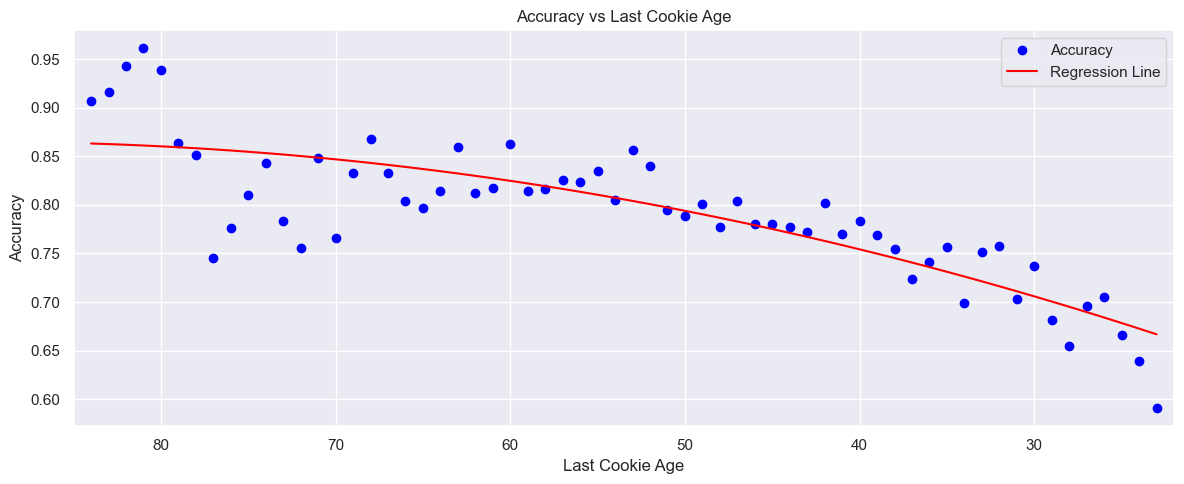

In [167]:
# plt.plot(accuracy_by_age, 'o-')
plt.plot(x, y, 'o', label='Accuracy', color='blue')
plt.plot(x, coeffs[0] + coeffs[1] * x + coeffs[2] * x**2, '-', label='Regression Line', color="red")
# plt.plot(accuracy_by_age.index, b + m * accuracy_by_age.index, '-', label='Regression Line')
plt.xlim(success_rate_by_age.index.max()+1, success_rate_by_age.index.min()-1)
# plt.errorbar(x, y, yerr=success_rate_by_age_std[::-1], fmt='o-', capsize=4, ecolor="grey")
# plt.errorbar(x, y, yerr=stds, fmt='o-', capsize=4, ecolor="grey")
plt.xlabel('Last Cookie Age')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Last Cookie Age')
plt.legend()
plt.tight_layout()
plt.show()

In [140]:
success_rate_by_age_std

last_cookie_age
23    0.492120
24    0.480364
25    0.471762
26    0.456046
27    0.460119
        ...   
80    0.239245
81    0.192779
82    0.231956
83    0.277770
84    0.291712
Name: mergeable_full, Length: 62, dtype: float64

In [170]:
accuracy_by_age.index

Int64Index([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
            57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84],
           dtype='int64', name='last_cookie_age')